<a href="https://colab.research.google.com/github/allefbcc/projetoCienciaDeDados-Walmart/blob/main/forecasting-notebook-group-6/N2_forecasting_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão vendas totais

## Importando bibliotecas

In [ ]:
!pip install mlforecast
!pip install dill

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsRegressor
from mlforecast.target_transforms import LocalMinMaxScaler
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import dill as pickle
import tempfile
import os

## Carregando DataFrame

In [ ]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [ ]:
data = pd.read_parquet(bucket_uri)

In [ ]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,value,date
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,2011-01-29
...,...,...,...,...,...,...,...,...
59181085,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1,2016-05-22
59181086,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,2016-05-22
59181087,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,2,2016-05-22
59181088,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,2016-05-22


In [ ]:
data2 = data[['value', 'date']]

In [ ]:
data2

,value,date
0,0,2011-01-29
1,0,2011-01-29
2,0,2011-01-29
3,0,2011-01-29
4,0,2011-01-29
...,...,...
59181085,1,2016-05-22
59181086,0,2016-05-22
59181087,2,2016-05-22
59181088,0,2016-05-22


In [ ]:
data2['date'] = pd.to_datetime(data2['date'])

/var/tmp/ipykernel_22494/1200454673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['date'] = pd.to_datetime(data2['date'])


In [ ]:
data2.set_index('date', inplace=True)

In [ ]:
data_diaria = data2['value'].resample('D').sum().reset_index()

In [ ]:
data_diaria

,date,value
0,2011-01-29,32631
1,2011-01-30,31749
2,2011-01-31,23783
3,2011-02-01,25412
4,2011-02-02,19146
...,...,...
1936,2016-05-18,37096
1937,2016-05-19,36963
1938,2016-05-20,42552
1939,2016-05-21,51518


## Transformando dados para o padrão do NIXTLA

In [ ]:
 data_diaria =  data_diaria.rename(columns={'date': 'ds', 'value': 'y'})

In [ ]:
 data_diaria['unique_id'] = 'vendas'

In [ ]:
 data_diaria

,ds,y,unique_id
0,2011-01-29,32631,vendas
1,2011-01-30,31749,vendas
2,2011-01-31,23783,vendas
3,2011-02-01,25412,vendas
4,2011-02-02,19146,vendas
...,...,...,...
1936,2016-05-18,37096,vendas
1937,2016-05-19,36963,vendas
1938,2016-05-20,42552,vendas
1939,2016-05-21,51518,vendas


## Separando dados em treinamento e teste

In [ ]:
data_train, data_test = train_test_split(data_diaria, test_size=0.2, shuffle=False)

In [ ]:
data_train

,ds,y,unique_id
0,2011-01-29,32631,vendas
1,2011-01-30,31749,vendas
2,2011-01-31,23783,vendas
3,2011-02-01,25412,vendas
4,2011-02-02,19146,vendas
...,...,...,...
1547,2015-04-25,43598,vendas
1548,2015-04-26,43406,vendas
1549,2015-04-27,33444,vendas
1550,2015-04-28,29750,vendas


In [ ]:
data_test

,ds,y,unique_id
1552,2015-04-30,30553,vendas
1553,2015-05-01,40976,vendas
1554,2015-05-02,47052,vendas
1555,2015-05-03,49102,vendas
1556,2015-05-04,38169,vendas
...,...,...,...
1936,2016-05-18,37096,vendas
1937,2016-05-19,36963,vendas
1938,2016-05-20,42552,vendas
1939,2016-05-21,51518,vendas


In [ ]:
data_full = pd.concat([data_train, data_test])

## Analisando o grafico de autocorrelação

In [ ]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

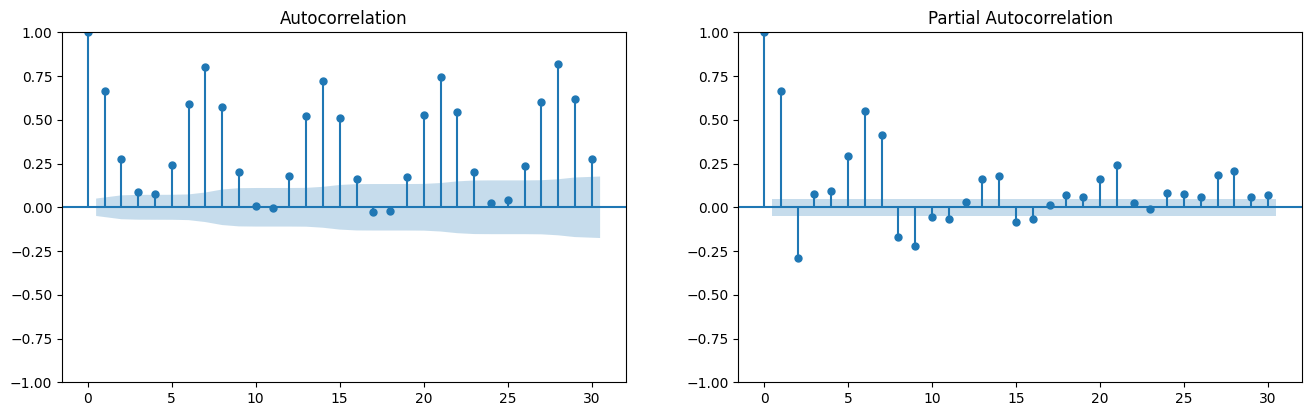

In [ ]:
acf_pacf(data_train['y'], 30)

## Treinamento do modelo e Previsão de vendas

In [ ]:
models = [
    RandomForestRegressor(n_estimators=50, random_state=0),
    KNeighborsRegressor(n_neighbors=3),
]

In [ ]:
mlf = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf.fit(data_train)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
forecasts = mlf.predict(395)

In [ ]:
data_test = data_test.merge(forecasts, how='left', on=['unique_id', 'ds'])

In [ ]:
data_test

,ds,y,unique_id,RandomForestRegressor,KNeighborsRegressor
0,2015-04-30,30553,vendas,35133.902344,37313.332031
1,2015-05-01,40976,vendas,40991.839844,40941.667969
2,2015-05-02,47052,vendas,43808.339844,43188.003906
3,2015-05-03,49102,vendas,30898.839844,34445.335938
4,2015-05-04,38169,vendas,34417.937500,35654.667969
...,...,...,...,...,...
384,2016-05-18,37096,vendas,33159.847656,33087.000000
385,2016-05-19,36963,vendas,33060.500000,30462.998047
386,2016-05-20,42552,vendas,32639.738281,34374.000000
387,2016-05-21,51518,vendas,35599.281250,33634.000000


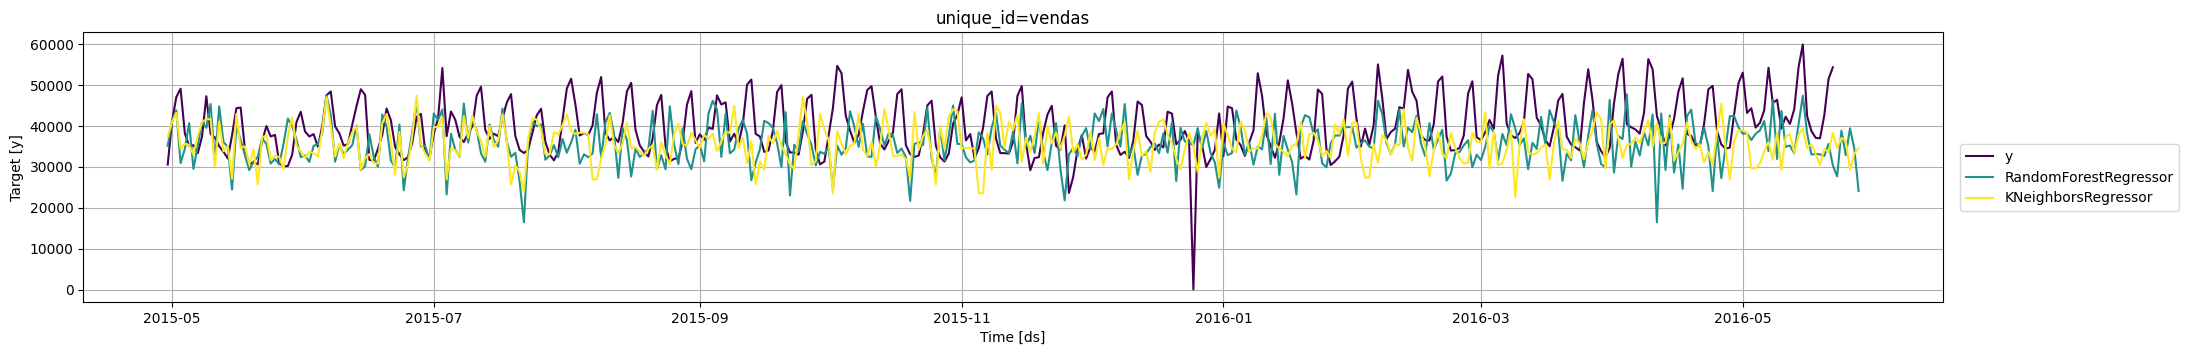

In [ ]:
plot_series(data_test, forecasts, plot_random=False)

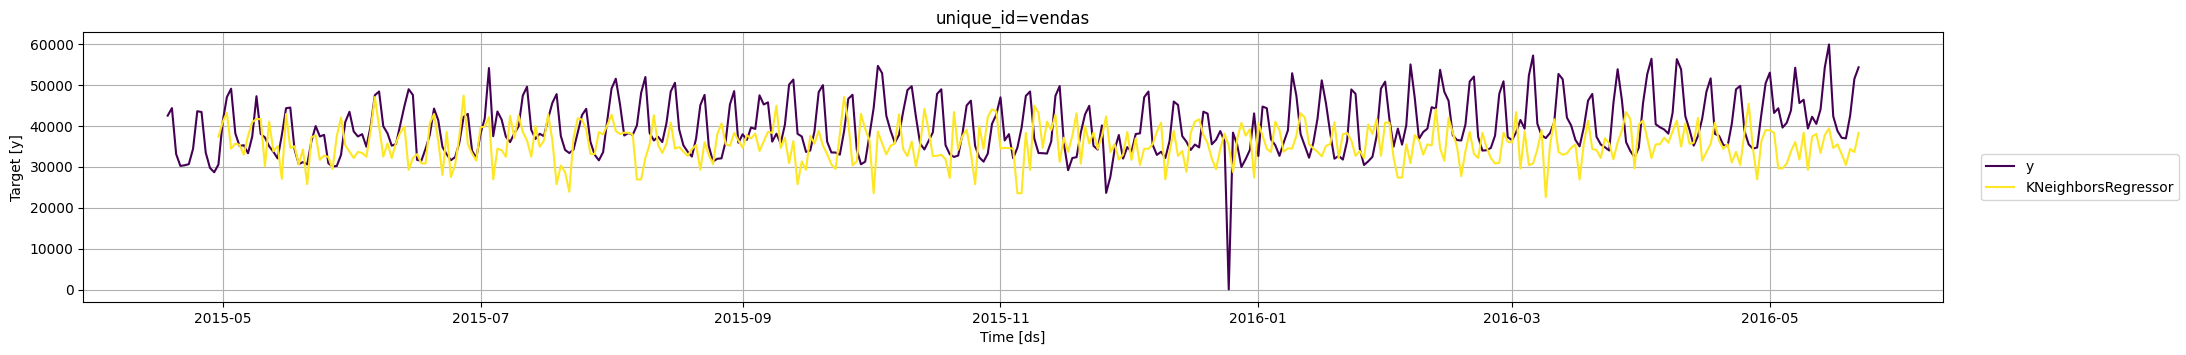

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['KNeighborsRegressor'],
    max_insample_length=12
)
fig

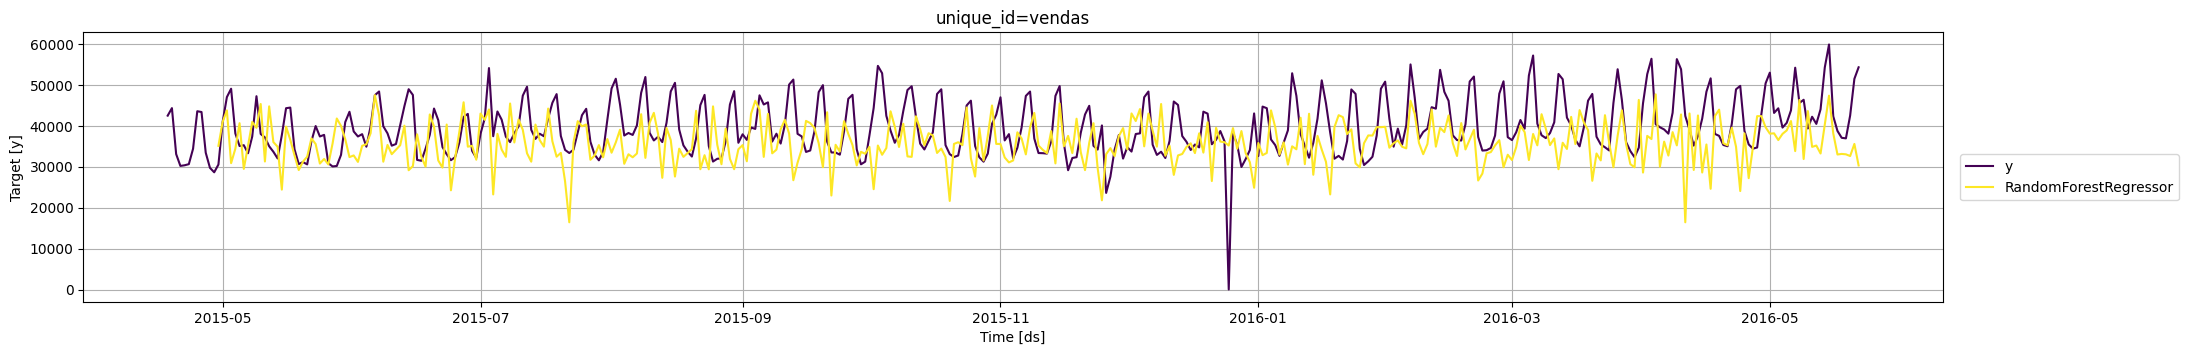

In [ ]:
fig = plot_series(
    data_train,
    data_test,
    plot_random=False,
    models=['RandomForestRegressor'],
    max_insample_length=12
)
fig

In [ ]:
metrics = []

# Calcular as métricas para cada unique_id
unique_ids = data_test['unique_id'].unique()
for unique_id in unique_ids:
    subset = data_test[data_test['unique_id'] == unique_id]
    y_true = subset['y']

    # Previsões do RandomForestRegressor
    y_pred_rf = subset['RandomForestRegressor']
    mae_rf = mean_absolute_error(y_true, y_pred_rf)
    mse_rf = mean_squared_error(y_true, y_pred_rf)
    r2_rf = r2_score(y_true, y_pred_rf)
    mape_rf = MAPE(y_true, y_pred_rf)

    # Previsões do KNeighborsRegressor
    y_pred_knn = subset['KNeighborsRegressor']
    mae_knn = mean_absolute_error(y_true, y_pred_knn)
    mse_knn = mean_squared_error(y_true, y_pred_knn)
    r2_knn = r2_score(y_true, y_pred_knn)
    mape_knn = MAPE(y_true, y_pred_knn)

    # Adicionar métricas ao dataframe
    metrics.append({
        'unique_id': unique_id,
        'MAE_RF': mae_rf,
        'MSE_RF': mse_rf,
        'R2_RF': r2_rf,
        'MAPE_RF': mape_rf,
        'MAE_KNN': mae_knn,
        'MSE_KNN': mse_knn,
        'R2_KNN': r2_knn,
        'MAPE_KNN': mape_knn
    })

# Criar um DataFrame com as métricas
metrics_df = pd.DataFrame(metrics)

# Exibir o DataFrame
metrics_df

,unique_id,MAE_RF,MSE_RF,R2_RF,MAPE_RF,MAE_KNN,MSE_KNN,R2_KNN,MAPE_KNN
0,vendas,6923.749478,8.348138e+07,-0.828552,6.625512,6933.203903,8.114650e+07,-0.777409,6.62144


## Previsão 6 meses

In [ ]:
mlf_full = MLForecast(
    models=models,
    freq='D',
    target_transforms=[LocalMinMaxScaler()],
    lags=[90]
)
mlf_full.fit(data_full)

MLForecast(models=[RandomForestRegressor, KNeighborsRegressor], freq=D, lag_features=['lag90'], date_features=[], num_threads=1)

In [ ]:
previsao_6meses = mlf_full.predict(180)

In [ ]:
previsao_6meses

,unique_id,ds,RandomForestRegressor,KNeighborsRegressor
0,vendas,2016-05-23,33115.261719,32238.001953
1,vendas,2016-05-24,34321.417969,37030.335938
2,vendas,2016-05-25,39354.941406,40809.667969
3,vendas,2016-05-26,32207.419922,33481.332031
4,vendas,2016-05-27,43447.179688,42400.335938
...,...,...,...,...
175,vendas,2016-11-14,25924.019531,38377.667969
176,vendas,2016-11-15,43223.281250,32464.335938
177,vendas,2016-11-16,38401.320312,42391.667969
178,vendas,2016-11-17,42557.300781,37282.332031


## Exportando pkl

In [ ]:
with open('ModelosPKL/vendas_totais.pkl', 'wb') as f:
    pickle.dump(mlf_full, f)

## Exportando previsão de 6 meses

In [ ]:
previsao_6meses.to_csv('Previsoes/previsao_estados.csv', index=False)